In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random
import seaborn as sns
from sklearn import datasets
from tqdm import tqdm

%matplotlib inline

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torch.autograd import grad

SEED = 999
torch.manual_seed(SEED)

In [4]:
plt.rcParams.update({'font.size': 20})

In [5]:
path = './input/'
os.listdir(path)

[]

In [6]:
class SyntheticDataGenerator(object):
    """superclass of all synthetic data. WARNING: doesn't raise StopIteration so it loops forever!"""

    def __iter__(self):
        return self

    def __next__(self):
        return self.get_batch()

    def get_batch(self):
        raise NotImplementedError()

    def float_tensor(self, batch):
        return torch.from_numpy(batch).type(torch.FloatTensor)


In [7]:
class StandardGaussianGenerator(SyntheticDataGenerator):
    """samples from Standard Gaussian."""

    def __init__(self,
                 batch_size: int=256,
                 scale: float=1.,
                 eps_noise: float=1.):
        self.batch_size = batch_size
        scale = scale
        self.eps_noise = eps_noise

    def get_batch(self):
        batch = []
        for _ in range(self.batch_size):
            point = np.random.randn(2) * self.eps_noise
            batch.append(point)
        batch = np.array(batch, dtype='float32')
        batch = self.float_tensor(batch)
        batch = batch[torch.randperm(batch.size(0)), :]
        return batch


In [8]:
class Eight_GMM_Generator(SyntheticDataGenerator):
    """samples from four 2D gaussians."""

    def __init__(self,
                 batch_size: int=256,
                 scale: float=10.,
                 eps_noise: float=.5):
        self.batch_size = batch_size
        scale = scale
        self.eps_noise = eps_noise

        centers = [
            (1,0),
            (-1,0),
            (0,1),
            (0,-1),
            (1./np.sqrt(2), 1./np.sqrt(2)),
            (1./np.sqrt(2), -1./np.sqrt(2)),
            (-1./np.sqrt(2), 1./np.sqrt(2)),
            (-1./np.sqrt(2), -1./np.sqrt(2))
        ]
        
        self.centers = [(scale*x,scale*y) for x,y in centers]

    def get_batch(self):
        batch = []
        for i in range(self.batch_size):
            
            point = np.random.randn(2) * self.eps_noise
            center = self.centers[i % 8]
            point[0] += center[0]
            point[1] += center[1]
            batch.append(point)

        batch = np.array(batch, dtype='float32')
        batch = self.float_tensor(batch)
        batch = batch[torch.randperm(batch.size(0)), :]
        return batch

In [9]:
## Gaussian to Gaussian
Id = 2
N = 10000


In [10]:
x_data = Eight_GMM_Generator(N)
x_batch = next(x_data)
x_batch.shape

torch.Size([10000, 2])

In [11]:
y_data = StandardGaussianGenerator(N)
y_batch = next(y_data)
y_batch.shape

torch.Size([10000, 2])

In [12]:
P = x_batch.numpy()
Q = y_batch.numpy()

Q.shape, P.shape

((10000, 2), (10000, 2))

In [13]:
mu_q = Q[:,:2].mean(axis=0)
mu_p = P[:,:2].mean(axis=0)

mu_q, mu_p

(array([-0.00165132, -0.00747791], dtype=float32),
 array([ 0.00352776, -0.00106544], dtype=float32))

In [15]:
Q.shape, P.shape

((10000, 2), (10000, 2))

In [16]:
x = torch.FloatTensor(P[:3]).cuda()
y = torch.FloatTensor(Q[:3]).cuda()
x.shape, y.shape

(torch.Size([3, 2]), torch.Size([3, 2]))

In [17]:
class Ki(nn.Module):
    def __init__(self, features = 128):
        super(Ki, self).__init__()
        
        self.W0b0 = nn.Linear(in_features=Id, out_features=features)
        
        self.W1b1 = nn.Linear(in_features=features, out_features=features)
        
        self.W2b2 = nn.Linear(in_features=features, out_features=features)
        
        self.W3b3 = nn.Linear(in_features=features, out_features=Id)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.W0b0(x))
        x = F.leaky_relu(self.W1b1(x))
        x = F.leaky_relu(self.W2b2(x))
        op = self.W3b3(x)
        
        return op
        

In [18]:
ki = Ki().cuda()
summary(ki,(1,Id))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]             384
            Linear-2               [-1, 1, 128]          16,512
            Linear-3               [-1, 1, 128]          16,512
            Linear-4                 [-1, 1, 2]             258
Total params: 33,666
Trainable params: 33,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [19]:
class Psi(nn.Module):
    def __init__(self, features = 128):
        super(Psi, self).__init__()
        
        self.W0b0 = nn.Linear(in_features=Id, out_features=features)
        
        self.W1b1 = nn.Linear(in_features=features, out_features=features)
        
        self.W2b2 = nn.Linear(in_features=features, out_features=features)
        
        self.W3b3 = nn.Linear(in_features=features, out_features=1)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.W0b0(x))
        x = F.leaky_relu(self.W1b1(x))
        x = F.leaky_relu(self.W2b2(x))
        op = self.W3b3(x)
        
        return op
        

In [20]:
psi = Psi().cuda()
summary(psi,(1,Id))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]             384
            Linear-2               [-1, 1, 128]          16,512
            Linear-3               [-1, 1, 128]          16,512
            Linear-4                 [-1, 1, 1]             129
Total params: 33,537
Trainable params: 33,537
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.13
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


In [21]:
torch.rand(1)

tensor([0.1378])

In [22]:
def PushForward(ki,x):
    gradPhi = ki(x)
    return gradPhi

In [23]:
def GradientPenalty(psi, ki, x, y):
    batch_size = x.shape[0]
    ip1 = nn.Parameter(x, requires_grad = True)
    ip2 = torch.mean(ki(ip1))
    
    eta =torch.rand(1).cuda()
    ip = nn.Parameter((eta*y+(1-eta)*ip2), requires_grad=True)
    op = torch.mean(psi(ip))
    
    # compute gradient penalty
    gp = torch.norm(grad(op, ip, create_graph=True)[0]*batch_size, 'fro', dim=1)
    gp = torch.mean((gp-1)**2)
    
    return gp

gp = GradientPenalty(psi, ki, x, y)
gp

tensor(0.8914, device='cuda:0', grad_fn=<MeanBackward0>)

In [24]:
def WassersteinLoss(psi,ki,x,y):
    yp = PushForward(ki,x)
    loss = (psi(y)- psi(yp)).mean()
    return loss

loss = WassersteinLoss(psi,ki,x,y)
loss

tensor(-0.0416, device='cuda:0', grad_fn=<MeanBackward0>)

In [25]:
T = 10001
M = 128
K_ki = 16
lam_gp =1.

parallel = True

In [26]:
psi = Psi()
ki = Ki()

if parallel:
    psi = nn.DataParallel(psi, [0,1])
    ki = nn.DataParallel(ki, [0,1])

psi.cuda()
ki.cuda()


DataParallel(
  (module): Ki(
    (W0b0): Linear(in_features=2, out_features=128, bias=True)
    (W1b1): Linear(in_features=128, out_features=128, bias=True)
    (W2b2): Linear(in_features=128, out_features=128, bias=True)
    (W3b3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [27]:
Ki_opt = optim.Adam(ki.parameters(), betas=(0.5,0.99), lr = 1e-3)
Psi_opt = optim.Adam(psi.parameters(), betas=(0.5,0.99), lr = 1e-3)

In [28]:
%%time
psi_l = []
ki_l = []
Gp_l = []

for t in tqdm(range(T)):
    y_idxs = random.sample(range(0,P.shape[0]), M)
    y_batch = torch.FloatTensor(P[y_idxs]).cuda()
    
    ## Multiple infimum updates to restrict exploding loss
    x_idxs = random.sample(range(0,Q.shape[0]), M)
    x_batch = torch.FloatTensor(Q[x_idxs]).cuda()

    ##########################################################
    ## Outer minimization loop
    ##########################################################       
    ## Fix Ki and update Psi to compute infimum. 
    for param in psi.parameters():
        param.requires_grad = True
    for param in ki.parameters():
        param.requires_grad = False

    gp_loss = GradientPenalty(psi, ki, x_batch, y_batch)
    Psi_loss = WassersteinLoss(psi, ki, x_batch, y_batch) + lam_gp * gp_loss

    Psi_opt.zero_grad()
    Psi_loss.backward(retain_graph=True)
    Psi_opt.step()


    psi_l.append(Psi_loss.item())
    Gp_l.append(gp_loss.item())

    ##########################################################
    ## Inner maximization loop: update once for every C updates
    ##########################################################
    ki_l_ = []
    for _ in range(K_ki):
        idxs = random.sample(range(0,P.shape[0]), M)
        y_batch = torch.FloatTensor(P[idxs]).cuda()
        x_batch = torch.FloatTensor(Q[idxs]).cuda()

        # print('Data: ', x_batch.shape, y_batch.shape)

        # sys.exit()
        ## Fix Psi and update Ki to compute convex conjugate/ supremum 
        for param in psi.parameters():
            param.requires_grad = False
        for param in ki.parameters():
            param.requires_grad = True

        Ki_loss = - WassersteinLoss(psi, ki, x_batch, y_batch) 

        Ki_opt.zero_grad()
        Ki_loss.backward(retain_graph=True)
        Ki_opt.step()

        ki_l_.append(Ki_loss.item())
    ki_l.append(np.asarray(ki_l_).mean())
        
    if t%100==0:
        print("Epoch: ", t,"|",T, "\t psi loss: ", np.round(psi_l[-1],3),"\t Gp loss: ",np.round(Gp_l[-1],2), "\t ki loss: ", np.round(ki_l[-1],2)) 
        
        

  0%|          | 1/10001 [00:06<17:35:15,  6.33s/it]

Epoch:  0 | 10001 	 psi loss:  0.785 	 Gp loss:  0.93 	 ki loss:  0.4


  1%|          | 101/10001 [00:31<39:09,  4.21it/s] 

Epoch:  100 | 10001 	 psi loss:  1.129 	 Gp loss:  0.93 	 ki loss:  -0.22


  2%|▏         | 202/10001 [00:47<25:27,  6.42it/s]

Epoch:  200 | 10001 	 psi loss:  1.632 	 Gp loss:  0.8 	 ki loss:  -0.77


  3%|▎         | 301/10001 [01:12<41:02,  3.94it/s]

Epoch:  300 | 10001 	 psi loss:  1.527 	 Gp loss:  0.88 	 ki loss:  -0.61


  4%|▍         | 401/10001 [01:35<37:34,  4.26it/s]

Epoch:  400 | 10001 	 psi loss:  1.527 	 Gp loss:  0.82 	 ki loss:  -0.57


  5%|▌         | 501/10001 [01:58<36:10,  4.38it/s]

Epoch:  500 | 10001 	 psi loss:  1.454 	 Gp loss:  0.77 	 ki loss:  -0.33


  6%|▌         | 601/10001 [02:20<36:37,  4.28it/s]

Epoch:  600 | 10001 	 psi loss:  0.646 	 Gp loss:  0.22 	 ki loss:  -0.28


  7%|▋         | 702/10001 [02:37<25:27,  6.09it/s]

Epoch:  700 | 10001 	 psi loss:  -0.022 	 Gp loss:  0.78 	 ki loss:  1.23


  8%|▊         | 802/10001 [02:54<24:54,  6.16it/s]

Epoch:  800 | 10001 	 psi loss:  -0.531 	 Gp loss:  0.82 	 ki loss:  1.1


  9%|▉         | 902/10001 [03:10<23:32,  6.44it/s]

Epoch:  900 | 10001 	 psi loss:  0.835 	 Gp loss:  0.33 	 ki loss:  -0.29


 10%|█         | 1001/10001 [03:29<39:11,  3.83it/s]

Epoch:  1000 | 10001 	 psi loss:  1.945 	 Gp loss:  0.5 	 ki loss:  -1.51


 11%|█         | 1101/10001 [03:55<39:35,  3.75it/s]

Epoch:  1100 | 10001 	 psi loss:  2.933 	 Gp loss:  0.25 	 ki loss:  -2.36


 12%|█▏        | 1201/10001 [04:20<36:11,  4.05it/s]

Epoch:  1200 | 10001 	 psi loss:  0.431 	 Gp loss:  0.2 	 ki loss:  0.59


 13%|█▎        | 1301/10001 [04:45<37:40,  3.85it/s]

Epoch:  1300 | 10001 	 psi loss:  3.903 	 Gp loss:  0.45 	 ki loss:  -2.58


 14%|█▍        | 1401/10001 [05:11<35:11,  4.07it/s]

Epoch:  1400 | 10001 	 psi loss:  1.74 	 Gp loss:  0.29 	 ki loss:  -0.33


 15%|█▌        | 1502/10001 [05:33<23:42,  5.97it/s]

Epoch:  1500 | 10001 	 psi loss:  0.224 	 Gp loss:  0.05 	 ki loss:  0.2


 16%|█▌        | 1601/10001 [05:57<34:47,  4.02it/s]

Epoch:  1600 | 10001 	 psi loss:  1.422 	 Gp loss:  0.05 	 ki loss:  -0.8


 17%|█▋        | 1701/10001 [06:22<35:18,  3.92it/s]

Epoch:  1700 | 10001 	 psi loss:  1.224 	 Gp loss:  0.15 	 ki loss:  -0.83


 18%|█▊        | 1801/10001 [06:47<33:43,  4.05it/s]

Epoch:  1800 | 10001 	 psi loss:  1.348 	 Gp loss:  0.36 	 ki loss:  -0.2


 19%|█▉        | 1901/10001 [07:12<32:36,  4.14it/s]

Epoch:  1900 | 10001 	 psi loss:  1.631 	 Gp loss:  0.11 	 ki loss:  -0.92


 20%|██        | 2001/10001 [07:38<34:44,  3.84it/s]

Epoch:  2000 | 10001 	 psi loss:  0.351 	 Gp loss:  0.08 	 ki loss:  0.32


 21%|██        | 2101/10001 [08:03<32:22,  4.07it/s]

Epoch:  2100 | 10001 	 psi loss:  -3.601 	 Gp loss:  0.02 	 ki loss:  5.13


 22%|██▏       | 2201/10001 [08:29<32:12,  4.04it/s]

Epoch:  2200 | 10001 	 psi loss:  1.522 	 Gp loss:  0.27 	 ki loss:  -0.98


 23%|██▎       | 2301/10001 [08:54<33:40,  3.81it/s]

Epoch:  2300 | 10001 	 psi loss:  0.115 	 Gp loss:  0.2 	 ki loss:  0.59


 24%|██▍       | 2402/10001 [09:18<22:14,  5.70it/s]

Epoch:  2400 | 10001 	 psi loss:  1.235 	 Gp loss:  0.39 	 ki loss:  -0.59


 25%|██▌       | 2501/10001 [09:43<33:20,  3.75it/s]

Epoch:  2500 | 10001 	 psi loss:  2.734 	 Gp loss:  0.37 	 ki loss:  -2.04


 26%|██▌       | 2601/10001 [10:09<31:53,  3.87it/s]

Epoch:  2600 | 10001 	 psi loss:  0.142 	 Gp loss:  0.08 	 ki loss:  0.11


 27%|██▋       | 2701/10001 [10:33<31:54,  3.81it/s]

Epoch:  2700 | 10001 	 psi loss:  -0.142 	 Gp loss:  0.08 	 ki loss:  0.34


 28%|██▊       | 2802/10001 [10:52<19:40,  6.10it/s]

Epoch:  2800 | 10001 	 psi loss:  -0.282 	 Gp loss:  0.04 	 ki loss:  0.4


 29%|██▉       | 2901/10001 [11:13<31:20,  3.78it/s]

Epoch:  2900 | 10001 	 psi loss:  -0.107 	 Gp loss:  0.39 	 ki loss:  -1.11


 30%|███       | 3001/10001 [11:39<29:23,  3.97it/s]

Epoch:  3000 | 10001 	 psi loss:  4.275 	 Gp loss:  0.24 	 ki loss:  -3.31


 31%|███       | 3101/10001 [12:04<27:44,  4.15it/s]

Epoch:  3100 | 10001 	 psi loss:  -6.296 	 Gp loss:  0.63 	 ki loss:  8.36


 32%|███▏      | 3201/10001 [12:29<29:22,  3.86it/s]

Epoch:  3200 | 10001 	 psi loss:  -8.222 	 Gp loss:  0.28 	 ki loss:  5.57


 33%|███▎      | 3301/10001 [12:55<28:04,  3.98it/s]

Epoch:  3300 | 10001 	 psi loss:  0.111 	 Gp loss:  0.22 	 ki loss:  -0.23


 34%|███▍      | 3401/10001 [13:21<27:35,  3.99it/s]

Epoch:  3400 | 10001 	 psi loss:  -0.772 	 Gp loss:  0.07 	 ki loss:  0.9


 35%|███▌      | 3501/10001 [13:44<27:30,  3.94it/s]

Epoch:  3500 | 10001 	 psi loss:  -0.968 	 Gp loss:  0.12 	 ki loss:  1.56


 36%|███▌      | 3601/10001 [14:09<26:59,  3.95it/s]

Epoch:  3600 | 10001 	 psi loss:  0.179 	 Gp loss:  0.81 	 ki loss:  -0.14


 37%|███▋      | 3701/10001 [14:34<26:54,  3.90it/s]

Epoch:  3700 | 10001 	 psi loss:  6.576 	 Gp loss:  0.35 	 ki loss:  -5.67


 38%|███▊      | 3801/10001 [15:00<24:51,  4.16it/s]

Epoch:  3800 | 10001 	 psi loss:  5.403 	 Gp loss:  0.19 	 ki loss:  -3.32


 39%|███▉      | 3902/10001 [15:25<20:19,  5.00it/s]

Epoch:  3900 | 10001 	 psi loss:  -5.875 	 Gp loss:  0.13 	 ki loss:  7.18


 40%|████      | 4001/10001 [15:48<24:39,  4.05it/s]

Epoch:  4000 | 10001 	 psi loss:  9.967 	 Gp loss:  0.89 	 ki loss:  -9.08


 41%|████      | 4101/10001 [16:13<24:16,  4.05it/s]

Epoch:  4100 | 10001 	 psi loss:  0.355 	 Gp loss:  0.19 	 ki loss:  1.43


 42%|████▏     | 4201/10001 [16:39<24:18,  3.98it/s]

Epoch:  4200 | 10001 	 psi loss:  24.147 	 Gp loss:  0.94 	 ki loss:  -28.91


 43%|████▎     | 4301/10001 [17:04<24:23,  3.89it/s]

Epoch:  4300 | 10001 	 psi loss:  0.199 	 Gp loss:  0.16 	 ki loss:  0.2


 44%|████▍     | 4401/10001 [17:29<24:56,  3.74it/s]

Epoch:  4400 | 10001 	 psi loss:  -0.582 	 Gp loss:  0.09 	 ki loss:  0.92


 45%|████▌     | 4501/10001 [17:52<22:33,  4.06it/s]

Epoch:  4500 | 10001 	 psi loss:  -4.95 	 Gp loss:  0.18 	 ki loss:  6.37


 46%|████▌     | 4601/10001 [18:17<21:54,  4.11it/s]

Epoch:  4600 | 10001 	 psi loss:  -6.014 	 Gp loss:  0.34 	 ki loss:  7.64


 47%|████▋     | 4701/10001 [18:42<22:02,  4.01it/s]

Epoch:  4700 | 10001 	 psi loss:  -0.563 	 Gp loss:  0.31 	 ki loss:  1.46


 48%|████▊     | 4801/10001 [19:07<21:42,  3.99it/s]

Epoch:  4800 | 10001 	 psi loss:  2.752 	 Gp loss:  0.18 	 ki loss:  -1.29


 49%|████▉     | 4901/10001 [19:32<21:25,  3.97it/s]

Epoch:  4900 | 10001 	 psi loss:  -4.78 	 Gp loss:  0.35 	 ki loss:  5.82


 50%|█████     | 5001/10001 [19:57<20:51,  3.99it/s]

Epoch:  5000 | 10001 	 psi loss:  -6.2 	 Gp loss:  0.15 	 ki loss:  0.83


 51%|█████     | 5101/10001 [20:21<20:17,  4.02it/s]

Epoch:  5100 | 10001 	 psi loss:  -9.069 	 Gp loss:  0.8 	 ki loss:  9.93


 52%|█████▏    | 5201/10001 [20:46<20:18,  3.94it/s]

Epoch:  5200 | 10001 	 psi loss:  0.415 	 Gp loss:  0.11 	 ki loss:  0.47


 53%|█████▎    | 5302/10001 [21:04<12:48,  6.11it/s]

Epoch:  5300 | 10001 	 psi loss:  -2.241 	 Gp loss:  0.29 	 ki loss:  2.96


 54%|█████▍    | 5401/10001 [21:26<19:45,  3.88it/s]

Epoch:  5400 | 10001 	 psi loss:  -1.014 	 Gp loss:  0.02 	 ki loss:  1.77


 55%|█████▌    | 5501/10001 [21:52<19:15,  3.89it/s]

Epoch:  5500 | 10001 	 psi loss:  1.569 	 Gp loss:  0.34 	 ki loss:  -1.04


 56%|█████▌    | 5601/10001 [22:15<18:15,  4.02it/s]

Epoch:  5600 | 10001 	 psi loss:  0.571 	 Gp loss:  0.19 	 ki loss:  0.38


 57%|█████▋    | 5701/10001 [22:40<18:08,  3.95it/s]

Epoch:  5700 | 10001 	 psi loss:  -4.374 	 Gp loss:  0.27 	 ki loss:  5.77


 58%|█████▊    | 5801/10001 [23:06<17:34,  3.98it/s]

Epoch:  5800 | 10001 	 psi loss:  1.504 	 Gp loss:  0.17 	 ki loss:  -0.74


 59%|█████▉    | 5901/10001 [23:31<17:35,  3.89it/s]

Epoch:  5900 | 10001 	 psi loss:  3.215 	 Gp loss:  0.2 	 ki loss:  -2.45


 60%|██████    | 6001/10001 [23:56<17:16,  3.86it/s]

Epoch:  6000 | 10001 	 psi loss:  5.044 	 Gp loss:  0.37 	 ki loss:  -4.2


 61%|██████    | 6101/10001 [24:22<16:24,  3.96it/s]

Epoch:  6100 | 10001 	 psi loss:  -1.707 	 Gp loss:  0.18 	 ki loss:  2.91


 62%|██████▏   | 6201/10001 [24:48<16:08,  3.92it/s]

Epoch:  6200 | 10001 	 psi loss:  6.602 	 Gp loss:  0.69 	 ki loss:  -5.05


 63%|██████▎   | 6301/10001 [25:13<15:33,  3.96it/s]

Epoch:  6300 | 10001 	 psi loss:  -1.624 	 Gp loss:  0.06 	 ki loss:  0.94


 64%|██████▍   | 6401/10001 [25:36<14:41,  4.09it/s]

Epoch:  6400 | 10001 	 psi loss:  3.777 	 Gp loss:  0.33 	 ki loss:  -7.1


 65%|██████▌   | 6501/10001 [26:00<11:03,  5.27it/s]

Epoch:  6500 | 10001 	 psi loss:  -0.274 	 Gp loss:  0.14 	 ki loss:  1.09


 66%|██████▌   | 6601/10001 [26:26<14:21,  3.94it/s]

Epoch:  6600 | 10001 	 psi loss:  -3.658 	 Gp loss:  0.17 	 ki loss:  3.07


 67%|██████▋   | 6701/10001 [26:51<13:38,  4.03it/s]

Epoch:  6700 | 10001 	 psi loss:  0.793 	 Gp loss:  0.57 	 ki loss:  0.1


 68%|██████▊   | 6801/10001 [27:17<13:16,  4.02it/s]

Epoch:  6800 | 10001 	 psi loss:  1.942 	 Gp loss:  0.25 	 ki loss:  -1.27


 69%|██████▉   | 6901/10001 [27:42<12:59,  3.98it/s]

Epoch:  6900 | 10001 	 psi loss:  -1.984 	 Gp loss:  0.09 	 ki loss:  2.82


 70%|███████   | 7001/10001 [28:07<12:42,  3.94it/s]

Epoch:  7000 | 10001 	 psi loss:  1.029 	 Gp loss:  0.0 	 ki loss:  -0.94


 71%|███████   | 7101/10001 [28:33<12:10,  3.97it/s]

Epoch:  7100 | 10001 	 psi loss:  0.579 	 Gp loss:  0.33 	 ki loss:  -0.16


 72%|███████▏  | 7201/10001 [28:58<12:10,  3.83it/s]

Epoch:  7200 | 10001 	 psi loss:  0.512 	 Gp loss:  0.12 	 ki loss:  -0.24


 73%|███████▎  | 7301/10001 [29:24<11:40,  3.85it/s]

Epoch:  7300 | 10001 	 psi loss:  1.316 	 Gp loss:  0.38 	 ki loss:  -0.98


 74%|███████▍  | 7401/10001 [29:49<10:27,  4.15it/s]

Epoch:  7400 | 10001 	 psi loss:  -0.097 	 Gp loss:  0.06 	 ki loss:  0.4


 75%|███████▌  | 7502/10001 [30:12<07:12,  5.78it/s]

Epoch:  7500 | 10001 	 psi loss:  0.406 	 Gp loss:  0.39 	 ki loss:  0.13


 76%|███████▌  | 7601/10001 [30:37<10:10,  3.93it/s]

Epoch:  7600 | 10001 	 psi loss:  0.645 	 Gp loss:  0.05 	 ki loss:  -0.08


 77%|███████▋  | 7702/10001 [31:02<07:45,  4.94it/s]

Epoch:  7700 | 10001 	 psi loss:  -1.777 	 Gp loss:  0.38 	 ki loss:  2.33


 78%|███████▊  | 7802/10001 [31:18<05:46,  6.35it/s]

Epoch:  7800 | 10001 	 psi loss:  -8.916 	 Gp loss:  1.5 	 ki loss:  12.82


 79%|███████▉  | 7901/10001 [31:42<08:57,  3.90it/s]

Epoch:  7900 | 10001 	 psi loss:  -2.44 	 Gp loss:  0.26 	 ki loss:  3.64


 80%|████████  | 8001/10001 [32:08<08:02,  4.15it/s]

Epoch:  8000 | 10001 	 psi loss:  2.113 	 Gp loss:  0.35 	 ki loss:  -0.8


 81%|████████  | 8101/10001 [32:33<08:03,  3.93it/s]

Epoch:  8100 | 10001 	 psi loss:  7.772 	 Gp loss:  0.98 	 ki loss:  -6.52


 82%|████████▏ | 8201/10001 [32:59<07:34,  3.96it/s]

Epoch:  8200 | 10001 	 psi loss:  -1.096 	 Gp loss:  0.06 	 ki loss:  1.73


 83%|████████▎ | 8301/10001 [33:24<06:58,  4.06it/s]

Epoch:  8300 | 10001 	 psi loss:  -1.922 	 Gp loss:  0.1 	 ki loss:  2.78


 84%|████████▍ | 8401/10001 [33:48<06:29,  4.11it/s]

Epoch:  8400 | 10001 	 psi loss:  7.973 	 Gp loss:  0.36 	 ki loss:  -6.04


 85%|████████▌ | 8501/10001 [34:11<06:09,  4.06it/s]

Epoch:  8500 | 10001 	 psi loss:  3.41 	 Gp loss:  0.1 	 ki loss:  -2.27


 86%|████████▌ | 8601/10001 [34:35<05:35,  4.17it/s]

Epoch:  8600 | 10001 	 psi loss:  -0.44 	 Gp loss:  0.13 	 ki loss:  0.65


 87%|████████▋ | 8701/10001 [34:59<05:17,  4.10it/s]

Epoch:  8700 | 10001 	 psi loss:  1.512 	 Gp loss:  0.0 	 ki loss:  -0.44


 88%|████████▊ | 8801/10001 [35:22<04:49,  4.14it/s]

Epoch:  8800 | 10001 	 psi loss:  -0.118 	 Gp loss:  0.11 	 ki loss:  0.87


 89%|████████▉ | 8901/10001 [35:47<04:40,  3.92it/s]

Epoch:  8900 | 10001 	 psi loss:  -4.005 	 Gp loss:  0.31 	 ki loss:  5.52


 90%|█████████ | 9001/10001 [36:11<04:07,  4.04it/s]

Epoch:  9000 | 10001 	 psi loss:  0.512 	 Gp loss:  0.12 	 ki loss:  0.24


 91%|█████████ | 9101/10001 [36:36<03:48,  3.95it/s]

Epoch:  9100 | 10001 	 psi loss:  -4.262 	 Gp loss:  0.95 	 ki loss:  5.3


 92%|█████████▏| 9201/10001 [37:00<03:13,  4.14it/s]

Epoch:  9200 | 10001 	 psi loss:  0.711 	 Gp loss:  0.06 	 ki loss:  -0.49


 93%|█████████▎| 9301/10001 [37:25<02:47,  4.18it/s]

Epoch:  9300 | 10001 	 psi loss:  1.655 	 Gp loss:  0.12 	 ki loss:  -2.7


 94%|█████████▍| 9401/10001 [37:49<02:26,  4.09it/s]

Epoch:  9400 | 10001 	 psi loss:  0.34 	 Gp loss:  0.01 	 ki loss:  0.14


 95%|█████████▌| 9501/10001 [38:12<01:59,  4.19it/s]

Epoch:  9500 | 10001 	 psi loss:  -0.584 	 Gp loss:  0.06 	 ki loss:  0.76


 96%|█████████▌| 9601/10001 [38:36<01:38,  4.08it/s]

Epoch:  9600 | 10001 	 psi loss:  0.661 	 Gp loss:  0.1 	 ki loss:  -0.59


 97%|█████████▋| 9701/10001 [39:00<01:11,  4.17it/s]

Epoch:  9700 | 10001 	 psi loss:  -0.443 	 Gp loss:  0.08 	 ki loss:  1.0


 98%|█████████▊| 9801/10001 [39:25<00:49,  4.05it/s]

Epoch:  9800 | 10001 	 psi loss:  1.835 	 Gp loss:  0.07 	 ki loss:  -0.85


 99%|█████████▉| 9901/10001 [39:47<00:19,  5.11it/s]

Epoch:  9900 | 10001 	 psi loss:  0.825 	 Gp loss:  0.06 	 ki loss:  -0.58


100%|██████████| 10001/10001 [40:12<00:00,  4.03it/s]

Epoch:  10000 | 10001 	 psi loss:  -0.228 	 Gp loss:  0.13 	 ki loss:  0.63
CPU times: user 41min 1s, sys: 7min 2s, total: 48min 4s
Wall time: 40min 12s


In [30]:
plt.rcParams.update({'font.size': 30})

In [32]:
## Compute Transport plan
n = 200
indxs = random.sample(range(0,P.shape[0]), n)

y = torch.FloatTensor(P[indxs]).cuda()
x = torch.FloatTensor(Q[indxs]).cuda()
Tx = PushForward(ki,x)

x.shape, y.shape, Tx.shape

(torch.Size([200, 2]), torch.Size([200, 2]), torch.Size([200, 2]))

In [33]:
x = x.detach().cpu().numpy()
y = y.detach().cpu().numpy()
Tx = Tx.detach().cpu().numpy()
mu_t = Tx.mean(axis=0)

x.shape, y.shape, Tx.shape

((200, 2), (200, 2), (200, 2))

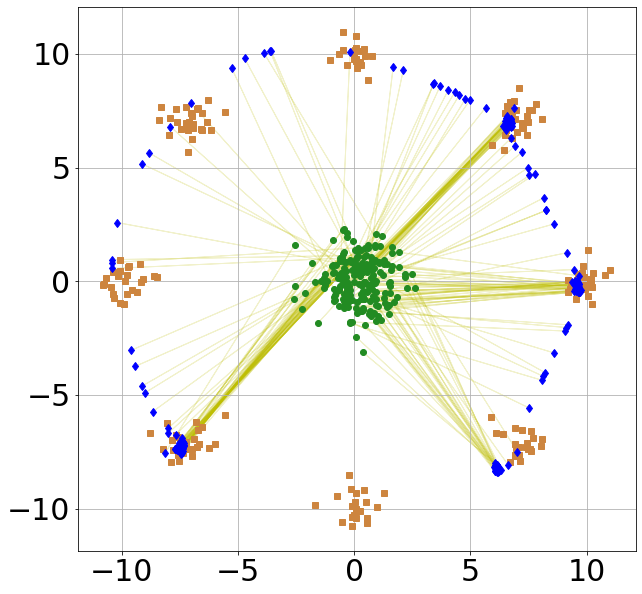

In [34]:
plt.figure(figsize=(10,10))
plt.plot(x[:,0],x[:,1],'og',label='Input (x)', color='forestgreen')
plt.plot(y[:,0],y[:,1],'s',label='Output (y)', color='peru')
plt.plot(Tx[:,0],Tx[:,1],'d',label='Transport (Tx)', color='blue')

for i in range(x.shape[0]):
    plt.arrow(x[i,0], x[i,1], Tx[i,0] - x[i,0], Tx[i,1] - x[i,1],  alpha=0.2, head_width=0.03, head_length = 0.05, fc='y', ec = 'y', color='y')

# plt.legend()
plt.grid()

plt.savefig('./output/Toy/WGAN_GP_Barry8Gauss_grid.pdf', bbox_inches='tight')


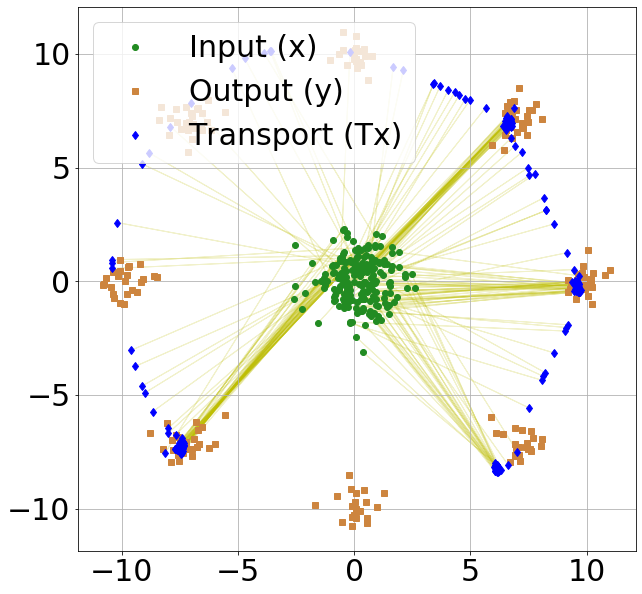

In [35]:
plt.figure(figsize=(10,10))
plt.plot(x[:,0],x[:,1],'og',label='Input (x)', color='forestgreen')
plt.plot(y[:,0],y[:,1],'s',label='Output (y)', color='peru')
plt.plot(Tx[:,0],Tx[:,1],'d',label='Transport (Tx)', color='blue')

for i in range(x.shape[0]):
    plt.arrow(x[i,0], x[i,1], Tx[i,0] - x[i,0], Tx[i,1] - x[i,1],  alpha=0.2, head_width=0.03, head_length = 0.05, fc='y', ec = 'y', color='y')

plt.legend()
plt.grid('off')

plt.savefig('./output/Toy/WGAN_GP_Barry8Gauss.jpg', bbox_inches='tight')
